# Masking

In [1]:
import os
import cv2
import csv
from tqdm import tqdm
import kornia as K
import kornia.feature as KF
import kornia.morphology as morph
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import torch
import torch.nn.functional as F
# from kornia_moons.viz import draw_LAF_matches
import skimage as ski
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from loftr import * 
from DatasetTools.LeafImageSeries import LeafDataset
from DatasetTools.LeafImageSeries import KeypointEditor

## Loading Images

In [2]:
base_dir = '../leaf-image-sequences'
# base_dir = '../test-webdav-sequences'
print(os.path.exists(base_dir))
print(os.path.exists(base_dir+'/raw'))

True
True


In [ ]:
base_dir = '../leaf-image-sequences'
# base_dir = '../test-webdav-sequences'
assert os.path.exists(base_dir), "Path to base directory invalid"
assert os.path.exists(base_dir+'/raw'), "Base directory empty"

leaf = LeafDataset(
    base_dir=base_dir,
    # leaf_uid="ESWW0090057_18", 
    leaf_uid="ESWW0070020_1", 
    # load=('images', 'rois', 'tforms', 'target_masks', 'leaf_masks', 'instance_masks', 'det_masks', 'seg_masks', 'target_images', "keypoints")
    load=('images', 'rois', "keypoints"),
    verbose=True
)

Initializing dataset...
Getting Series...
Getting paths...


In [3]:
available_data = {
            key: value for key, value in leaf.__dict__.items()
            if not key.startswith('_') and value is not None
        }
available_data.keys()

dict_keys(['base_dir', 'leaf_uid', 'series', 'image_uids', 'output_base', 'output_reg', 'output_ts', 'shift_affine', 'images', 'rois', 'keypoints'])

In [4]:
available_data['rois'][3]
# available_data['rois'][3]['rotation_matrix']

{'rotation_matrix': [[0.9999479121098008,
   -0.010206520820045598,
   28.097566878620377],
  [0.010206520820045598, 0.9999479121098008, -41.66360516288263]],
 'bounding_box': [[1343, 3176], [6287, 3176], [6287, 3987], [1343, 3987]],
 'transformation_matrix': [[0.9926017441720136,
   -0.03645819677532361,
   10.838102190732412],
  [0.00492382188196885, 1.016519616054494, -18.09833064407817],
  [2.143680248720033e-06, -2.2731286925450572e-05, 1.0]]}

## Aligning Keypoints

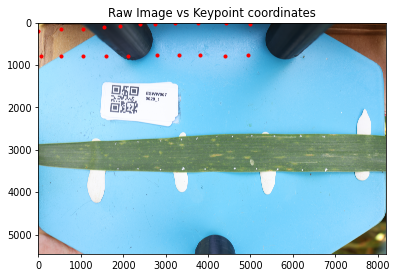

In [5]:
index = 4
plt.figure(dpi=70)
plt.imshow(available_data['images'][index])
plt.scatter(available_data['keypoints'][index][:,0], available_data['keypoints'][index][:,1], c='red', s=10 )
plt.title("Raw Image vs Keypoint coordinates")
plt.show()

In [6]:
# convert keypoint coords to full image coords
kpts_img = keypoints_roi_to_image(available_data['keypoints'][index], available_data['rois'][index])

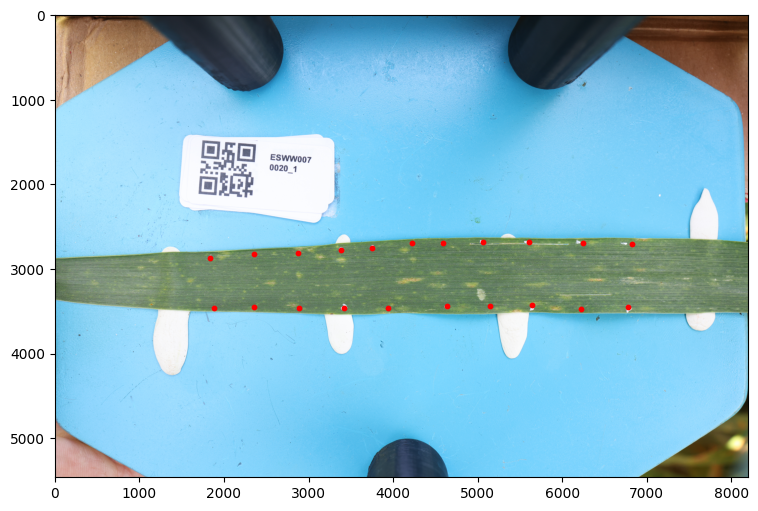

In [7]:
plt.figure(figsize=(12,6))
plt.imshow(available_data['images'][index])
plt.scatter(kpts_img[:,0], kpts_img[:,1], c='red', s=10 )
plt.show()

## Masking & Erosion

In [10]:
masked_img, mask_t, center = mask_leaf(available_data['images'][index], kpts_img, erode_px=20)

erosion not yet functional


In [62]:
# mean = np.mean(hull, axis=0)
# print(f"mean = {mean}")
# mx = np.max(hull, axis=0)
# mn = np.min(hull, axis=0)
# mid = (mx+mn)/2
# print(f"min = {mn}, max = {mx}")
# print(f"mid = {mid}")

mean = [[4884.5  3000.25]]
min = [[1830 2675]], max = [[6831 3469]]
mid = [[4330.5 3072. ]]


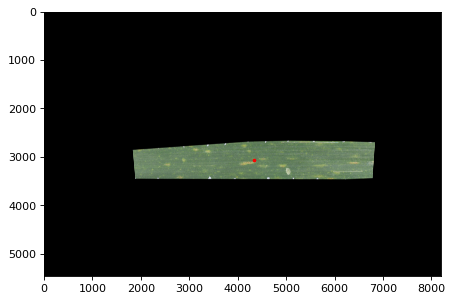

In [11]:
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(masked_img))
plt.scatter(center[0][0], center[0][1], c='red', s=5, label='center')
# plt.scatter(mean[0][0], mean[0][1], c='yellow', s=5, label='mean')
# plt.scatter(mid[0][0], mid[0][1], c='cyan', s=5, label='middle')
plt.show()

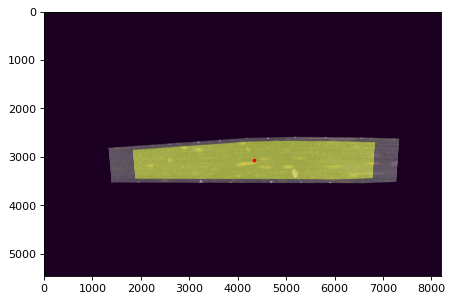

In [ ]:
img_scaled = scale_image(masked_img, 1.2, center)

plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(img_scaled))
plt.imshow(K.tensor_to_image(mask_t), alpha=0.4)
plt.scatter(center[0][0], center[0][1], c='red', s=5)
plt.show()

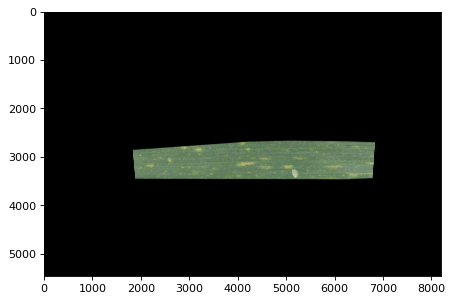

In [13]:
masked_scaled_img = img_scaled * mask_t 
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(masked_scaled_img))
plt.show()

In [25]:
# eroded_mask = erode_mask_by_scaling(mask_t, scale=0.9)

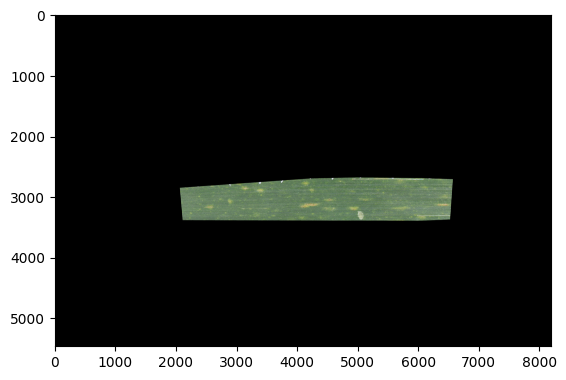

In [20]:
# masked_scaled_img = masked_img * eroded_mask
# plt.figure(dpi=80)
# plt.imshow(K.tensor_to_image(masked_scaled_img))
# plt.show()

### LoFTR Quick Test

In [29]:
H=1366 
W=2048 
moving_img = K.geometry.resize(masked_scaled_img, (H, W), antialias=True)
fixed_img = pil_to_kornia(available_data['images'][0])
fixed_img = K.geometry.resize(fixed_img, (H, W), antialias=True)

Total matches: 802
Matches with Confidence > 0.5: 377
Inliers: 214 (26.68%)


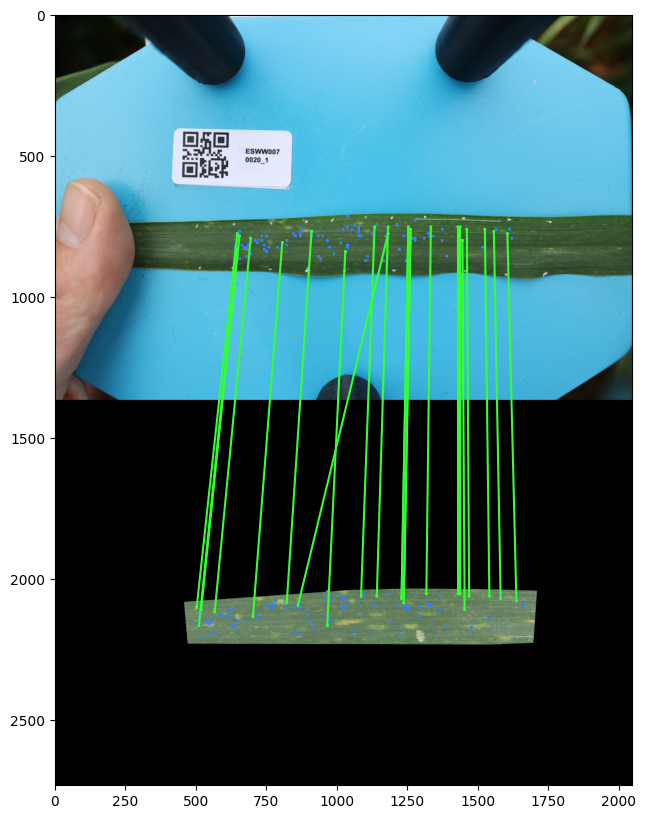

In [30]:
mkpts1, mkpts2, confidence, inliers = loftr_match(fixed_img, moving_img)

# plot matches
fig, ax = plot_matches(fixed_img, mkpts1, moving_img, mkpts2, inliers, inliers_only=False)
fig.show()

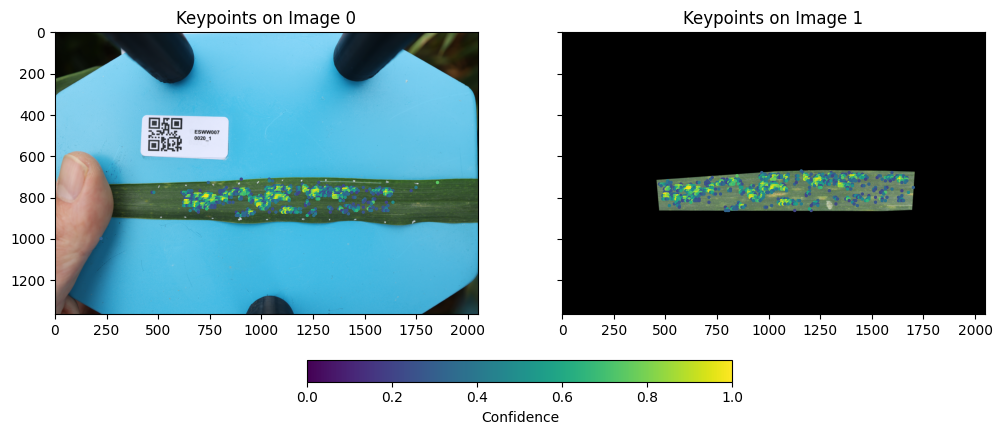

In [31]:
fig, axs = plot_match_coverage(fixed_img, mkpts1, moving_img, mkpts2, confidence)
fig.show()

## LoFTR

In [13]:
# ind = 2 
# img0 = available_data['images'][index]
# img1 = available_data['images'][index+1]
# keypts_img0 = keypoints_roi_to_image(available_data['keypoints'][index], available_data['rois'][index])
# keypts_img1 = keypoints_roi_to_image(available_data['keypoints'][index+1], available_data['rois'][index+1])

In [14]:
# masked_img0, mask_t0 = mask_leaf(img0, keypts_img0)
# masked_img1, mask_t1 = mask_leaf(img1, keypts_img1)

In [15]:
# eroded_mask0 = erode_mask_by_scaling(mask_t0, scale=0.9)
# eroded_mask1 = erode_mask_by_scaling(mask_t1, scale=0.9)

In [16]:
# masked_scaled_img0 = masked_img0 * eroded_mask0
# masked_scaled_img1 = masked_img1 * eroded_mask1

In [ ]:
# plt.imshow(K.tensor_to_image(masked_scaled_img1))
# plt.show()

## Robustness Test

- rotation: 0 → ±30° (steps: 5°)
- translation: 0 → ±20% image width/height (steps: 5%)
- scale: 1.0 → 0.6–1.4 (steps: 0.1)
- brightness/contrast/gamma: 1.0 → [0.5, 1.5] (steps: 0.1)
- hue shift: 0 → ±0.1 (normalized) (steps: 0.02)
- saturation: 1.0 → [0.5, 1.5] (steps: 0.1)
- gaussian noise: σ = 0 → 0–25 (pixel value std, steps: 5)
- gaussian blur: kernel size 1 → 1,3,5,7
- ( jpeg quality: 100 → 100, 85, 60, 40, 20 )
- ( occlusion (cutout): occlusion area 0% → up to 40% of image (steps: 5–10%) )

In [4]:
# transforms = {
#     'rotation': [10],#list(range(-30, 35, 5)),        # -30,...,-5,0,5,10,...,30 degrees
#     'translation': [10], #list(range(-20, 25, 5)),     # +/- 20% of image width/height
#     'scale': [1.5], #list(range(0.5, 1.5, 0.1)),        # 0.5-1.5
#     'brightness': [0.2], #[0.0, 0.1, 0.2, 0.4, 0.5],    # 0 = no changes
#     'contrast': [1.0], #[1.0, 0.9, 0.8, 0.7, 0.6],      # 1 = no changes, 0 = completely black
#     'gamma': [1.0], #[0.8, 0.9, 1.0, 1.1, 1.2],         # <1 -> dark regions lighter, >1 -> dark regions darker
#     'hue': [0.05],# list(range(-0.1, 0.1, 0.05)),       # 0 = no shift
#     'saturation': [1.5],#list(range(0.5, 1.5, 0.1)),    # 1 = no changes, 0 = black&white, >1 = more saturated
#     # 'gaussian_noise': [5],#[0, 5, 10, 15, 20],
    
# }

transforms = {
    'Rotation': list(range(-30, 40, 10)),        # -30,...,-5,0,5,10,...,30 degrees
    'Translation': list(range(-20, 30, 10)),     # +/- 20% of image width/height
    'Scale': [0.5, 0.75, 1.25, 1.5], #list(range(0.5, 1.5, 0.25)),        # 0.5-1.5
    'Brightness': [0.1, 0.3, 0.5], #[0.0, 0.1, 0.2, 0.4, 0.5],    # 0 = no changes
    'Contrast': [0.8, 0.6], #[1.0, 0.9, 0.8, 0.7, 0.6],      # 1 = no changes, 0 = completely black
    'Gamma': [0.8, 1.0, 1.2], #[0.8, 0.9, 1.0, 1.1, 1.2],         # <1 -> dark regions lighter, >1 -> dark regions darker
    'Hue': [-0.05, 0.05],# list(range(-0.1, 0.1, 0.05)),       # 0 = no shift
    'Saturation': [0.75, 1.25],#list(range(0.5, 1.5, 0.1)),    # 1 = no changes, 0 = black&white, >1 = more saturated
    'Gaussian Noise': [0.5],#[0, 0.25, 0.5, 0.75, 1],           # 0 = no changes, higher = more noise
    'Gaussian Blur': [21, 51],#[11, 21, 51, 101, 151],
    
}
size_factors = [4,8]#[1, 2, 4, 8]

In [34]:
fixed_img_ind = 1
moving_img_ind = 13
fixed_img = erode_leaf(available_data, index=fixed_img_ind)
moving_img = erode_leaf(available_data, index=moving_img_ind)
height = available_data['images'][0].size[1]
width = available_data['images'][0].size[0]

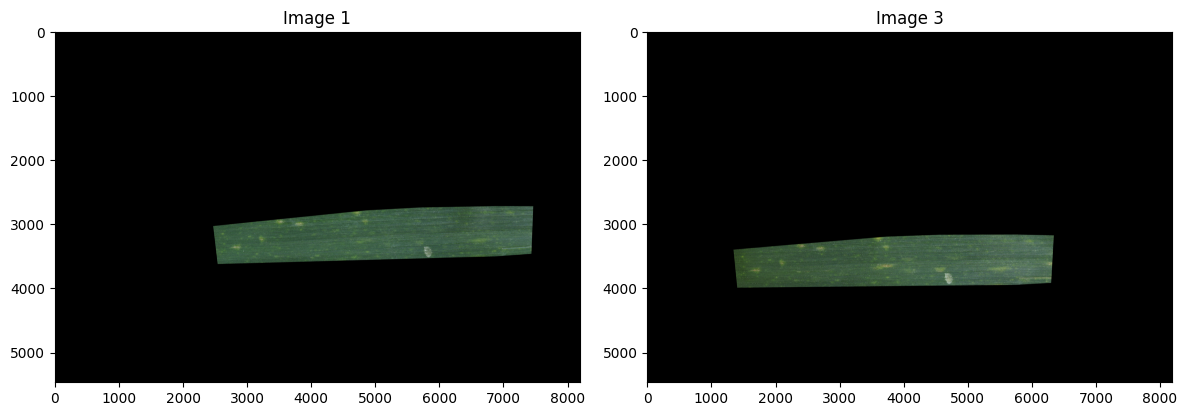

In [ ]:
plot_image_pair(fixed_img, moving_img, fixed_img_ind, moving_img_ind, title="Eroded Images")
plt.show()

In [7]:
def affine(img, rot_angle_deg=0, fx=0, fy=0, scale=1.0):
    # add batch dim if necessary
    if img.dim() == 3:
        img = img.unsqueeze(0)
    
    B,C,H,W = img.shape
    tx = W*fx/100
    ty = H*fy/100
    angle = torch.tensor([rot_angle_deg], dtype=img.dtype, device=img.device).repeat(B)
    scale = torch.tensor([scale, scale], dtype=img.dtype, device=img.device).repeat(B,1)
    center = torch.tensor([[img.shape[-1]/2, img.shape[-2]/2]], dtype=img.dtype, device=img.device).repeat(B,1)
    translation = torch.tensor([[tx, ty]], dtype=img.dtype, device=img.device).repeat(B,1)
    matrix = K.geometry.transform.get_affine_matrix2d(translation, center, scale, angle)
    return K.geometry.transform.warp_affine(img, matrix[:,:2,:], dsize=(H, W))

def adjust_color(img, brightness=0.0, contrast=0.0, saturation=1.0):
    # brightness ∈ [-1, 1], contrast > 0
    img = K.enhance.adjust_brightness(img, brightness)
    img = K.enhance.adjust_contrast(img, contrast+1e-6)
    img = K.enhance.adjust_saturation(img, saturation)
    K.enhance.adjust_gamma()
    return img

def gaussian_blur(img, kernel_size=0.0, sigma=0.0):
    # add batch dim if necessary
    if img.dim() == 3:
        img = img.unsqueeze(0)

    blur = K.filters.GaussianBlur2d((kernel_size, kernel_size), (sigma, sigma))

    return blur(img)

def add_gaussian_noise(img, sigma=0.0):
    noise = torch.randn_like(img)  # Generating on GPU is fastest with `torch.randn_like(...)`
    if sigma != 1.0:  # `if` is cheaper than multiplication
        noise *= sigma
    return (img + noise).clamp(0,1)

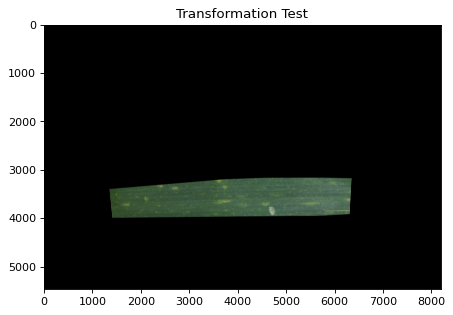

In [42]:
# trsf = K.augmentation.RandomAffine(30, (0.2, 0.2), (0.5, 1.5))
# test = trsf(moving_img)
test = affine(moving_img, 10, 10, -10, 1)
# test = adjust_color(moving_img, 1.5, 1.5)
# test = add_gaussian_noise(moving_img, sigma=0.5)
magnitude = 11
# test = K.filters.gaussian_blur2d(moving_img, kernel_size=torch.tensor([magnitude, magnitude]), sigma=torch.tensor([magnitude, magnitude]),)
test= gaussian_blur(moving_img, kernel_size=magnitude, sigma=magnitude)
plt.figure(dpi=80)
plt.imshow(K.tensor_to_image(test))
plt.title("Transformation Test")
plt.show()

In [8]:
def transform_img(img, transform_name, magnitude):
    # geometric
    if transform_name == "Rotation":
        return affine(img, rot_angle_deg=magnitude, fx=0, fy=0, scale=1.0)
    if transform_name == "Translate":
        return affine(img, rot_angle_deg=0, fx=magnitude, fy=magnitude, scale=1.0)
    if transform_name == "Scale":
        return affine(img, rot_angle_deg=0, fx=0, fy=0, scale=magnitude)

    # intensity
    if transform_name == "Brightness":
        return K.enhance.adjust_brightness(img, magnitude)
    if transform_name == "Contrast":
        return K.enhance.adjust_contrast(img, magnitude)
    if transform_name == "Saturation":
        return K.enhance.adjust_saturation(img, magnitude)
    if transform_name == "Gamma":
        return K.enhance.adjust_gamma(img, magnitude)
    if transform_name == "Hue":
        return K.enhance.adjust_hue(img, magnitude)

    # noise / blur
    if transform_name == "Gaussian Noise":
        return add_gaussian_noise(img, sigma=magnitude)
    if transform_name == "Gaussian Blur":
        return gaussian_blur(moving_img, kernel_size=magnitude, sigma=magnitude)
   
    # add more as needed
    return img

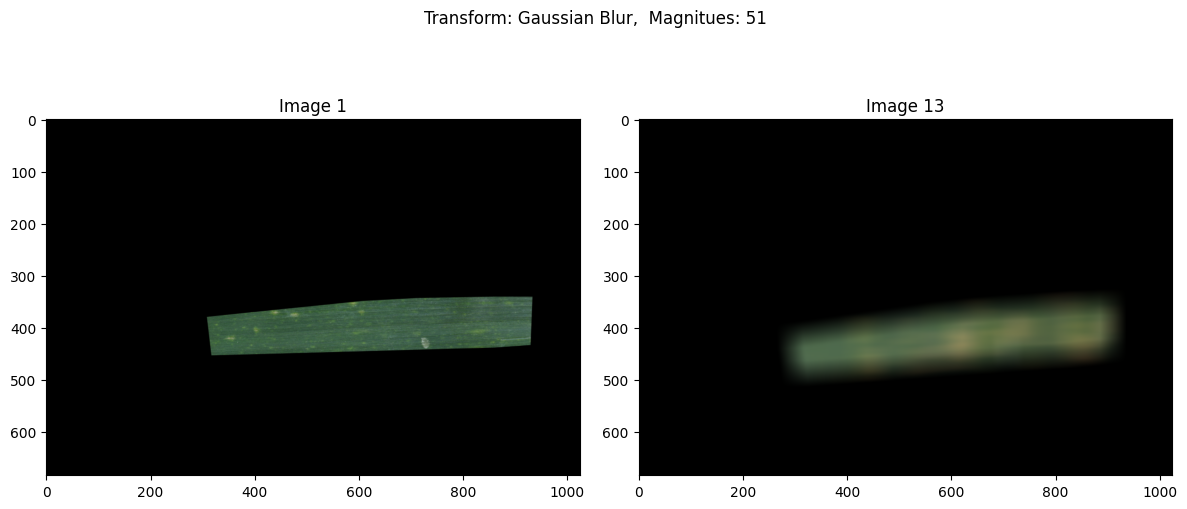

In [35]:
from IPython.display import clear_output, display, DisplayHandle

out_file = "robustness_results copy.csv"
file_exists = os.path.exists(out_file)

handle = display(display_id=True)

with open(out_file, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['fixed_image', 'moving_image', 'size','transform','magnitude','total_matches', 'conf_matches', 'inliers'])
    
    if not file_exists: # if file is new, write the header
        writer.writeheader()

    for size_factor in size_factors:
        H = int(height/size_factor)
        W = int(width/size_factor)  
        fixed_img = K.geometry.resize(fixed_img, (H, W), antialias=True)
        moving_img = K.geometry.resize(moving_img, (H, W), antialias=True) 

        # original images
        fixed_img_raw = pil_to_kornia(available_data['images'][fixed_img_ind])
        moving_img_raw = pil_to_kornia(available_data['images'][moving_img_ind])
        fixed_img_raw = K.geometry.resize(fixed_img_raw, (H, W), antialias=True)
        moving_img_raw = K.geometry.resize(moving_img_raw, (H, W), antialias=True)

        fig, _ = plot_image_pair(fixed_img_raw, moving_img_raw, fixed_img_ind, moving_img_ind)#, title=f"Original Images,   Size: 1/{size_factor}")
        handle.update(fig)   
        plt.close(fig)
        _, _, _, _, n_matches = loftr_match(fixed_img_raw, moving_img_raw, verbose=False, return_n_matches=True)
        writer.writerow({'fixed_image': fixed_img_ind, 'moving_image': moving_img_ind, 'size': f"1/{size_factor}", 'transform': 'original image', 'magnitude': 'none', 'total_matches': n_matches['total_matches'], 'conf_matches': int(n_matches['conf_matches']), 'inliers': n_matches['inliers']})

        for tname, magnitudes in transforms.items():
            for mag in magnitudes:
                # clear_output(wait=True)
                # print(f"Transform: {tname},     Magnitues: {mag}")
                transformed_img = transform_img(moving_img, tname, mag)

                # plot current image pair
                fig, _ = plot_image_pair(fixed_img, transformed_img, fixed_img_ind, moving_img_ind)#, title=f"Transform: {tname},  Magnitues: {mag},   Size: 1/{size_factor}")
                fig.suptitle(f"Transform: {tname},  Magnitues: {mag}")
                handle.update(fig)   
                plt.close(fig)

                _, _, _, _, n_matches = loftr_match(fixed_img, transformed_img, verbose=False, return_n_matches=True)
                writer.writerow({'fixed_image': fixed_img_ind, 'moving_image': moving_img_ind, 'size': f"1/{size_factor}", 'transform': tname, 'magnitude': mag, 'total_matches': n_matches['total_matches'], 'conf_matches': int(n_matches['conf_matches']), 'inliers': n_matches['inliers']})